<div class="alert alert-info">
    <h1>Global Fire Power Analysis 2024</h1>
</div>

## Resumen

Este ejercicio tiene como objetivo principal el agrupar a países según su poder militar.

Como objetivo secundario se busca entender cómo afecta el **escalamiento de los datos** en técnicas de descomposición y conglomeración.

Para poder cumplir con el objetivo se emplearon técnicas como:
- Escalamiento **mínimo-máximo** `sklearn.preprocessing.MinMaxScaler`
- Descomposición/Reducción de dimensionalidad con **PCA** `sklearn.decomposition.PCA`
- Clusterización con **K-Means** `sklearn.cluster.KMeans`

## Takeways

- El centroide es el promedio de las variables de todas las observaciones/puntos dentro de un mismo cluster.
  - `pd.DataFrame.groupby('cluster').mean() -> centroides`
- El método del codo utiliza la diferencia euclediana de los valores de la observación vs. los valores promedio del centroide del cluster al que pertenece.
  - `np.linalg.norm(x - u_i) == np.sqrt(((x - u_i) ** 2).sum()): True`
- Para este caso en particular, el escalar la información con el min-max scaler (`sklearn.preprocess.MinMaxScaler`) parece no modificar la distribución de las variables. Es posible que otro tipo de escalador pudiera hacer que los atributos de los países se pudiera hacer más normal.
  - Al poder tener una distribución más normal podría influir en los clusters generados.
- El escalar si bien no tuvo impacto directo/visible sobre la distribución de las variables y su correlación, si parece afectar:
  - El número de componentes principales del algoritmo **PCA** (`sklearn.decomposition.PCA`) necesarios para explicar una varianza del ~93%. Paso de necesitar solo 2 componentes con información no escalada a 5 con información escalada.
  - Al momento de agrupar con **K-means** (`sklearn.cluster.KMeans`) con data escalada y emplear la prueba del codo se observó que 3 era el número de clusters optimo que minimizaba el error `WCSS`, algo que no era tan claro con información no escalada.
  - Esto último influyo en la gráfica bi-dimensional de los países con los primeros dos componentes principales, los cuáles dieron ideas relativamente diferentes entre información escalada y no.

In [1]:
%%html
<style>

    .indicators {
        display: flex;
        padding: 5%;
    }
    
    .row-of-indicators {
        display: flex;
        align-items: center;
        justify-content: center;
        left-padding: auto;
        height: auto;
        /* border: 1px solid white; debugging */
    }

    .indicator-el {
        width: 25%;
        height: 100%;
        padding: 1vh;
        /* border: 1px solid blue; debugging */
    }

    .indicator-el img {
        width: 50vh;
        height: 25vh;
    }

    .indicator-el p {
        text-align: center;
        height: 20%;
    }
</style>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 

import seaborn as sns
import geopandas as gpd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

## Importa/limpia la data

Importa los indicadores

In [4]:
data = pd.read_csv('gfp_countries_indicators.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   country_longName                           145 non-null    object
 1   country_shortName                          145 non-null    object
 2   Total population                           145 non-null    int64 
 3   Reaching Military Age                      145 non-null    int64 
 4   Active Service                             145 non-null    int64 
 5   Active Reserves                            145 non-null    int64 
 6   Paramilitary                               145 non-null    int64 
 7   Fighters/Interceptors                      145 non-null    int64 
 8   Attack/Strike                              145 non-null    int64 
 9   Helicopter Fleets                          145 non-null    int64 
 10  Armored Fighting Vehicles             

Vamos a quedarnos con las variables que esten directamente más relacionado con lo militar (activos)

In [5]:
# Define una lista con los activos militares
mil_vars = ['Active Service', 'Active Reserves', 'Paramilitary', 'Fighters/Interceptors', 
            'Attack/Strike', 'Helicopter Fleets', 'Armored Fighting Vehicles', 'Towed Artillery',
           'Submarines', 'Frigates', 'Corvettes']

data = data.set_index(['country_longName', 'country_shortName'])[mil_vars]
display(data.head(5), data.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 145 entries, ('Afghanistan', 'AFG') to ('Zimbabwe', 'ZIM')
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Active Service             145 non-null    int64
 1   Active Reserves            145 non-null    int64
 2   Paramilitary               145 non-null    int64
 3   Fighters/Interceptors      145 non-null    int64
 4   Attack/Strike              145 non-null    int64
 5   Helicopter Fleets          145 non-null    int64
 6   Armored Fighting Vehicles  145 non-null    int64
 7   Towed Artillery            145 non-null    int64
 8   Submarines                 145 non-null    int64
 9   Frigates                   145 non-null    int64
 10  Corvettes                  145 non-null    int64
dtypes: int64(11)
memory usage: 23.6+ KB


,,Active Service,Active Reserves,Paramilitary,Fighters/Interceptors,Attack/Strike,Helicopter Fleets,Armored Fighting Vehicles,Towed Artillery,Submarines,Frigates,Corvettes
country_longName,country_shortName,,,,,,,,,,,
Afghanistan,AFG,0,0,80000,0,0,11,6555,0,0,0,0
Albania,ALB,6600,2000,500,0,0,19,976,0,0,0,0
Algeria,ALG,325000,135000,150000,102,42,298,35990,483,6,8,16
Angola,ANG,107000,0,10000,57,26,116,5500,552,0,0,0
Argentina,ARG,108000,0,20000,24,10,90,21724,172,2,0,9


None

¿Cómo se ven visualmente estas variables?

<div>
    <div class="row-of-indicators">
        <div class="indicator-el">
            <img src="https://upload.wikimedia.org/wikipedia/commons/d/d1/F-106A_Chase_Dart_%28cropped%29.jpg" alt="fighters/interceptors">
            <p>Fighters/Interceptors aircraft</p>
        </div>
        <div class="indicator-el">
            <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Fairchild_Republic_A-10_Thunderbolt_II_-_32156159151.jpg/1200px-Fairchild_Republic_A-10_Thunderbolt_II_-_32156159151.jpg" alt="attack/strike">
            <p>Attack/Strike aircraft</p>
        </div>
        <div class="indicator-el">
            <img src="https://upload.wikimedia.org/wikipedia/commons/4/48/Jordanian_Air_Force_UH-60_Black_Hawk_helicopter_%28cropped%29.jpg" alt="helicopter-fleets">
            <p>Helicopter Fleets</p>
        </div>
    </div>
    <div class="row-of-indicators">
        <div class="indicator-el">
            <img src="https://eco-cdn.iqpc.com/eco/images/channel_content/images/boxer.webp" alt="armored-fighting-vehicles">
            <p>Armored Fighting Vehicles</p>
        </div>
        <div class="indicator-el">
            <img src="https://upload.wikimedia.org/wikipedia/commons/a/ac/M777_howitzer_rear.jpg" alt="towered-artillery">
            <p>Towed Artillery</p>
        </div>
    </div>
    <div class="row-of-indicators">
        <div class="indicator-el">
            <img src="https://upload.wikimedia.org/wikipedia/commons/b/bb/US_Navy_040730-N-1234E-002_PCU_Virginia_%28SSN_774%29_returns_to_the_General_Dynamics_Electric_Boat_shipyard.jpg" alt="submarines">
            <p>Submarines</p>
        </div>
        <div class="indicator-el">
            <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Admiral_Gorshkov_frigate_03.jpg/640px-Admiral_Gorshkov_frigate_03.jpg" alt="frigates">
            <p>Frigates</p>
        </div>
        <div class="indicator-el">
            <img src="https://upload.wikimedia.org/wikipedia/commons/d/d2/Zarechny_%28parade%29.jpg">
            <p>Corvettes</p>
        </div>
    </div>
</div>

## Sin escalar

### Describe las variables, muestra las distribuciones e identifica posibles correlaciones

In [6]:
# Describe las variables numericas
data.describe()

,Active Service,Active Reserves,Paramilitary,Fighters/Interceptors,Attack/Strike,Helicopter Fleets,Armored Fighting Vehicles,Towed Artillery,Submarines,Frigates,Corvettes
count,1.450000e+02,1.450000e+02,1.450000e+02,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,1.538843e+05,2.018092e+05,1.213070e+05,73.668966,27.234483,144.337931,16538.241379,407.441379,3.296552,2.820690,2.951724
std,2.968488e+05,5.759480e+05,6.096424e+05,209.141302,101.437584,506.244619,39810.587310,1014.412302,10.033364,5.507153,9.774777
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000
25%,1.840000e+04,0.000000e+00,2.000000e+03,0.000000,0.000000,13.000000,1112.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000e+04,2.600000e+04,1.250000e+04,11.000000,0.000000,38.000000,4522.000000,72.000000,0.000000,0.000000,0.000000
75%,1.620000e+05,1.300000e+05,5.500000e+04,53.000000,23.000000,100.000000,13710.000000,300.000000,2.000000,4.000000,2.000000
max,2.035000e+06,5.000000e+06,6.800000e+06,1854.000000,896.000000,5737.000000,360069.000000,8356.000000,65.000000,42.000000,83.000000


Notas

- Parece que muy pocos paises tienen `Submarines`, `Frigates` y `Corvettes` i.e. activos navales
- Los `Active Service`, `Active Reserves` y `Paralimitary` estan en millones de personas
- Los `Armored Fighting Vehicles` parece ser uno de los indicadores con mayores valores (miles) en comparación con otros equipos como barcos.

Genera las distribuciones de las variables

Text(0.5, 1.05, 'Distribución de las variables')

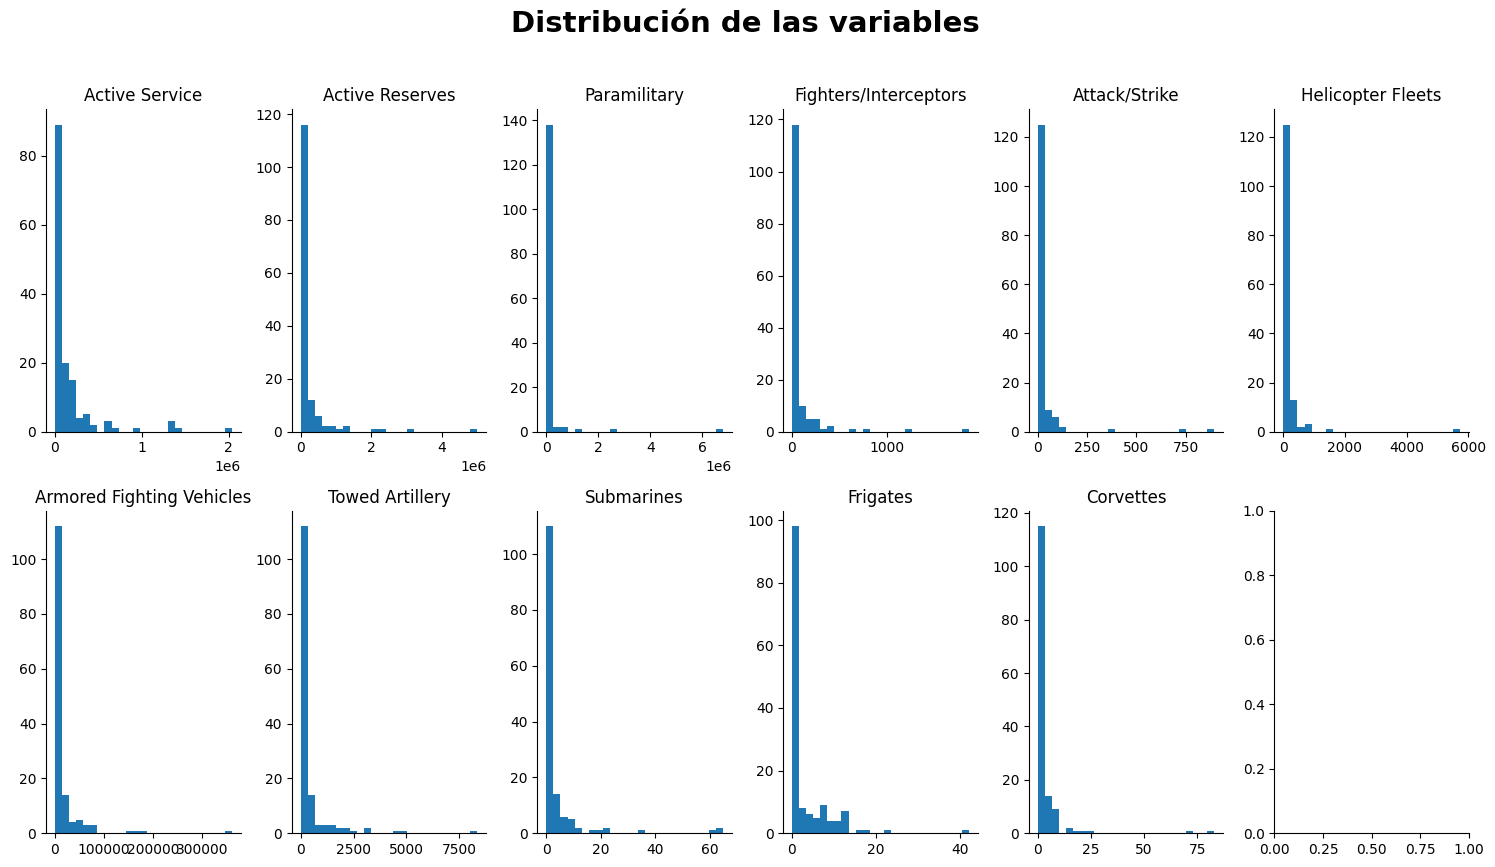

In [7]:
fig, axs = plt.subplots(2, 6, figsize=(15, 8))
axs = axs.flatten()

for i, col in enumerate(data.columns):
    ax = axs[i]
    ax.hist(data[col], bins=25)
    ax.set_title(col)

fig.tight_layout()
fig.text(0.5, 1.05, 'Distribución de las variables', weight='bold', ha='center', size=21)

Todas parecen estar sesgadas a la derecha i.e. las observaciones se concentran en la parte izquierda de las distribuciones.

#### ¿Hay algúna posible correlación?

<Axes: title={'center': 'Correlación líneal de las variables'}>

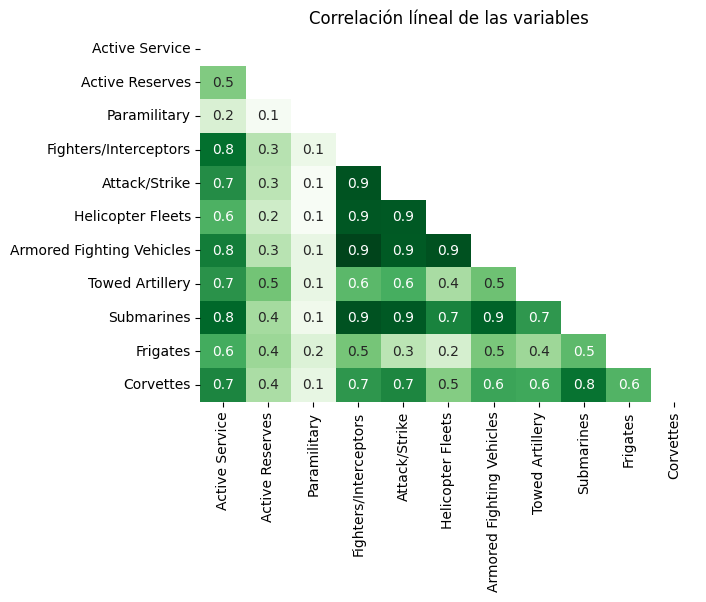

In [8]:
fig, ax = plt.subplots()

ax.set_title('Correlación líneal de las variables')
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Genera una mascara para quedarte con el triangulo inferior de la matriz
sns.heatmap(corr, mask=mask, ax=ax, annot=True, fmt='.1f', cmap='Greens', cbar=False)

- Se observa una alta correlación entre los `Active Service` y casi todas las variables, a excepción de `Paramilitary`. Esto sugiere que a mayor personal militar activo hay más equipo naval, aéreo y terrestre.
- De igual forma, se observa una alta correlación entre `Fighters/Interceptors` y el número de aeronaves `Attack/Strike`, `Helicopter Fleets`, `Armored Fighting Vehicles` y `Submarines`

#### ¿Es posible reducir la dimensionalidad?

Es posible, pero ¿nos dice algo?

In [9]:
# Intenta con 10 componentes principales y observa que tanta varianza explica
pca = PCA(n_components=10)
pca.fit(data)
display(list(map(lambda x: round(x, 4), pca.explained_variance_ratio_)))

# Interesante que con solo 2 componentes se explique gran parte de la varianza

[0.5025, 0.4181, 0.0786, 0.0008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Transforma la información inicial con el `PCA` entrenado

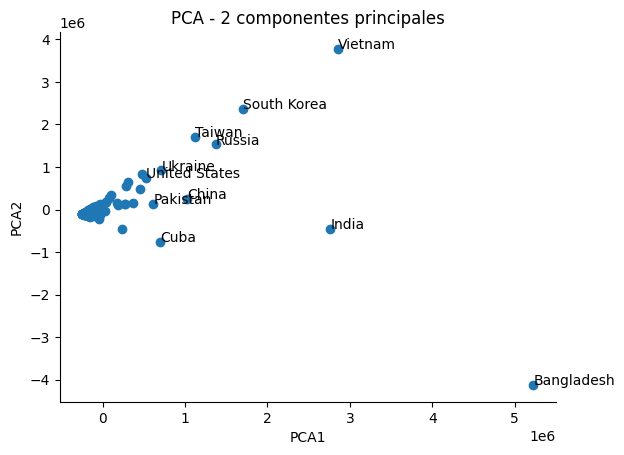

In [10]:
# Genera un dataframe y dale el formato necesario (nombre de columnas/indice)
data_pca = pd.DataFrame(pca.transform(data))
data_pca.columns = [f'PCA{i+1}' for i in data_pca.columns]
data_pca.index = data.index
data_pca = data_pca[['PCA1', 'PCA2']]

###############
# Grafica
###############
fig, ax = plt.subplots()
ax.scatter(data_pca['PCA1'], data_pca['PCA2'])

# Para aquellos paises que no estan concentrados, entonces graficalos
for index, row in data_pca.sort_values('PCA1', ascending=False).iloc[:11].iterrows():
    ax.text(row['PCA1'], row['PCA2'], index[0])

# Agrega aes
ax.set_title('PCA - 2 componentes principales')
ax.set_xlabel('PCA1')

_ = ax.set_ylabel('PCA2')

- Interesante que China, Rusia y EE.UU. esten cercanos, siendo estos países que se destacan por su poder militar. De igual forma, estan cerca de **Pakistán**, **Corea del Sur** y curiosamente **India**. Es probable que esta última se destaque por el número de población que se puede ver reflejado en población en servicio o reservas.
- Estos paises también se ven reflejados en el [2024 Military Strength Ranking](https://www.globalfirepower.com/countries-listing.php)

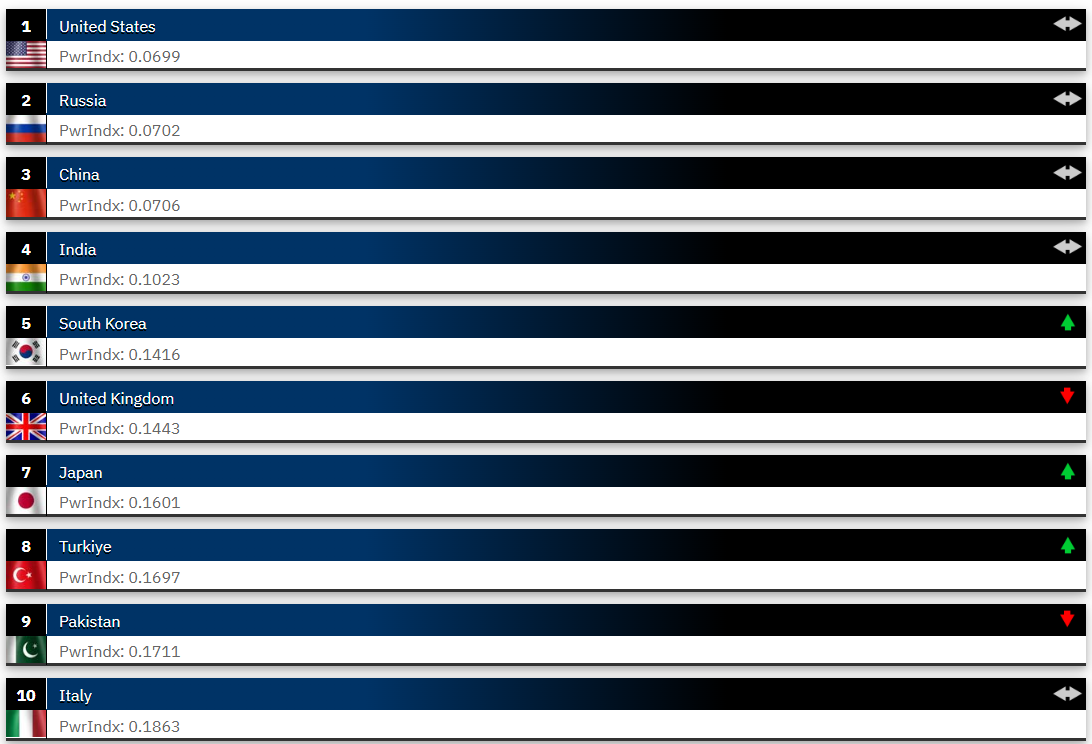

#### ¿Es posible hacer una agrupación con la información original?

¿Nos dice algo?

#### Seleccionando el número de Clusters

Para poder seleccionar el número de clusters "óptimo" se utilizará el método del codo, dónde se gráfica el `WCSS` contra el número de clusters para identificar el punto en el que el `WCSS` deja de decrecer de forma acelerada.

Según Gilabert, O. (2024) "el `WCSS` es básicamente una medida o métrica que nos aydua a entender cuán similares son los datos dentro de un mismo cluster". La fórmula para calcular el `WCSS` es la siguiente:

<img src="https://miro.medium.com/v2/resize:fit:574/format:webp/1*8wSEdBO1BIzHV3XhqpfV6Q.png" alt="formula_WCSS">

Donde:
- $k$ es el número de clusters
- $S_i$ representa el conjunto de puntos en el cluster $i$
- $x$ es n punto dentro del cluster $S_i$
- $u_i$ es el centroide del cluster $i$, es decir, el punto que repesenta el centro del cluster
- $||x - u_i||^2$ es la distancia al cuadrado entre el punto $x$ y el centroide $u_i$, lo que nos da una idea de "que tan lejos" esta cada punto de su centro.

En resumen, el `WCSS` es una métrica que nos ayuda de manera a reducir el "error" o la gran varianza entre los datos agrupados a un cluster y el centroide de este último.

#### Calculando el `CWSS` a mano

In [11]:
# Genera un K-means basico para poder emplear la formula a mano,
# mas alla de solo utilizar kmeans.inertia_
kmeans = KMeans(n_clusters=2, max_iter=10, random_state=11)
kmeans.fit(data)

# Genera una data para comprobar que nuestros resultados sean similares a los
# que calcula scikitlearn
clusters = kmeans.predict(data.copy())
data_comprueba = data.copy()
data_comprueba['cluster'] = clusters

# Obten los centroides de cada uno de los clusters entrenados y pegaselos a la data de comprobacion
clusters_centroids = pd.DataFrame(kmeans.cluster_centers_).reset_index()
clusters_centroids.columns = ['cluster'] + [f'media_{c}' for c in clusters_centroids.columns[1:]]
data_comprueba = pd.merge(data_comprueba, clusters_centroids, on='cluster', how='inner')

display('* Unique clusters', data_comprueba.groupby('cluster')['cluster'].count())

data_comprueba.head()

'* Unique clusters'

cluster
0    144
1      1
Name: cluster, dtype: int64

,Active Service,Active Reserves,Paramilitary,Fighters/Interceptors,Attack/Strike,Helicopter Fleets,Armored Fighting Vehicles,Towed Artillery,Submarines,Frigates,...,media_1,media_2,media_3,media_4,media_5,media_6,media_7,media_8,media_9,media_10
0,0,0,80000,0,0,11,6555,0,0,0,...,203210.659722,74927.222222,73.875,27.423611,144.833333,16562.118056,407.236111,3.305556,2.791667,2.930556
1,6600,2000,500,0,0,19,976,0,0,0,...,203210.659722,74927.222222,73.875,27.423611,144.833333,16562.118056,407.236111,3.305556,2.791667,2.930556
2,325000,135000,150000,102,42,298,35990,483,6,8,...,203210.659722,74927.222222,73.875,27.423611,144.833333,16562.118056,407.236111,3.305556,2.791667,2.930556
3,107000,0,10000,57,26,116,5500,552,0,0,...,203210.659722,74927.222222,73.875,27.423611,144.833333,16562.118056,407.236111,3.305556,2.791667,2.930556
4,108000,0,20000,24,10,90,21724,172,2,0,...,203210.659722,74927.222222,73.875,27.423611,144.833333,16562.118056,407.236111,3.305556,2.791667,2.930556


In [12]:
# Primero calcula la distancia entre la observacion y el centroide
WCSS = []
for k in data_comprueba['cluster'].unique():
    k_data = data_comprueba.query('cluster == @k')

    for i, row in k_data.iterrows():
        x = row.values[:11] # Vector de la observacion
        u_i = row.values[-11:] # Centroide del cluster
        distance = np.linalg.norm(x - u_i) ** 2 # Distance al cuadrado

        #################################
        # BONUS:
        # La euclidean distance de la diferencia de 2 vectors es igual a:
        # La raiz de La suma de la diferencia de los vectores al cuadrado (SS),
        # Muy similar al RMSE pero no exactamente
        # np.linalg.norm(x - u_i) == np.sqrt(((x - u_i) ** 2).sum())
        #################################

        WCSS.append(distance)
        
np.sum(WCSS) == kmeans.inertia_

False

#### Calcula el `k` clusters óptimo

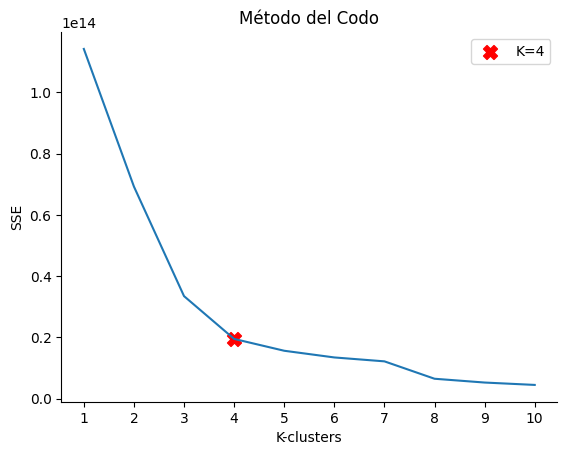

In [13]:
# Obten el WCSS de cada uno de los k clusters
WCSS = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=10000, random_state=11)
    kmeans.fit(data)
    WCSS.append(kmeans.inertia_)


# Grafica el codo
fig, ax = plt.subplots()
_ = np.arange(1, len(WCSS)+1)
ax.plot(_, WCSS)
ax.scatter(4, WCSS[3], color='red', marker='X', s=100, label='K=4')
plt.legend()

ax.set_xticks(_)
ax.set_xlabel('K-clusters')
ax.set_ylabel('SSE')
_ = ax.set_title('Método del Codo')

El codo se ve entre 3 y 4, vamos a dejarlo en el 4 de forma semi-arbitraria. Entonces entrena con el número de clusters óptimo.

In [14]:
# Entrena el algoritmo y predice
kmeans = KMeans(n_clusters=4, random_state=11)
kmeans.fit(data)

data_cluster = data.copy()
data_cluster['cluster'] = kmeans.predict(data_cluster)
data_cluster = data_cluster.reset_index()

# Cual es el numero de paises que se agruparon?
data_cluster.groupby('cluster')['country_shortName'].nunique()

cluster
0    134
1      1
2      3
3      7
Name: country_shortName, dtype: int64

In [15]:
for cluster, cluster_df in data_cluster.groupby('cluster'):
    print(f'> cluster={cluster}')
    display(cluster_df[['country_longName', 'country_shortName']].head(10))
    print()

> cluster=0


,country_longName,country_shortName
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,ALG
3,Angola,ANG
4,Argentina,ARG
5,Armenia,ARM
6,Australia,AUS
7,Austria,AST
8,Azerbaijan,AZR
9,Bahrain,BAH



> cluster=1


,country_longName,country_shortName
10,Bangladesh,BNG



> cluster=2


,country_longName,country_shortName
117,South Korea,SKO
126,Taiwan,TWN
141,Vietnam,VET



> cluster=3


,country_longName,country_shortName
28,China,CHN
53,India,IND
93,North Korea,NKO
97,Pakistan,PAK
107,Russia,RUS
134,Ukraine,UKR
137,United States,USA


¿Realmente nos sirve que tengamos 134 países en un mismo cluster, y tener solo 11 repartidos en 3 diferentes? No creo que sea la mejor forma de agrupar.

¿Cuáles son los centroides del `K-means`?

- Aquí se observa como los centroides de cada uno de los clusters usando `kmeans.cluster_centers_`, es lo mismo que agrupar por `cluster` y obtener el promedio.
- Un centroide no es más que el promedio de cada una de las variables, de todos los elementos que se encuentran dentro de un mismo cluster.

In [16]:
kmeans_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=data.columns)

display(
    kmeans_centroids
    .style
    .background_gradient(cmap='Greens', subset=['Active Service'])
    .background_gradient(cmap='Greens', subset=['Active Reserves'])
    .background_gradient(cmap='Greens', subset=['Paramilitary'])
    .background_gradient(cmap='Greens', subset=['Fighters/Interceptors'])
    .background_gradient(cmap='Greens', subset=['Attack/Strike'])
    .background_gradient(cmap='Greens', subset=['Helicopter Fleets'])
    .background_gradient(cmap='Greens', subset=['Armored Fighting Vehicles'])
    .background_gradient(cmap='Greens', subset=['Towed Artillery'])
    .background_gradient(cmap='Greens', subset=['Submarines'])
    .background_gradient(cmap='Greens', subset=['Frigates'])
    .background_gradient(cmap='Greens', subset=['Corvettes'])
    .format('{:,.0f}')
)

display(
    data_cluster[data_cluster.columns[2:]].groupby('cluster').mean()
     .style
    .background_gradient(cmap='Blues', subset=['Active Service'])
    .background_gradient(cmap='Blues', subset=['Active Reserves'])
    .background_gradient(cmap='Blues', subset=['Paramilitary'])
    .background_gradient(cmap='Blues', subset=['Fighters/Interceptors'])
    .background_gradient(cmap='Blues', subset=['Attack/Strike'])
    .background_gradient(cmap='Blues', subset=['Helicopter Fleets'])
    .background_gradient(cmap='Blues', subset=['Armored Fighting Vehicles'])
    .background_gradient(cmap='Blues', subset=['Towed Artillery'])
    .background_gradient(cmap='Blues', subset=['Submarines'])
    .background_gradient(cmap='Blues', subset=['Frigates'])
    .background_gradient(cmap='Blues', subset=['Corvettes'])
    .format('{:,.0f}')
)

,Active Service,Active Reserves,Paramilitary,Fighters/Interceptors,Attack/Strike,Helicopter Fleets,Armored Fighting Vehicles,Towed Artillery,Submarines,Frigates,Corvettes
0,"87,483","90,133","46,735",34,11,75,"9,968",216,1,2,1
1,"163,000",0,"6,800,000",44,0,73,"13,100",437,2,7,6
2,"471,667","3,470,000","141,667",227,44,364,"34,979","2,228",11,16,7
3,"1,287,507","967,786","586,000",768,340,"1,393","134,904","3,293",36,11,30


,Active Service,Active Reserves,Paramilitary,Fighters/Interceptors,Attack/Strike,Helicopter Fleets,Armored Fighting Vehicles,Towed Artillery,Submarines,Frigates,Corvettes
cluster,,,,,,,,,,,
0,"87,483","90,133","46,735",34,11,75,"9,968",216,1,2,1
1,"163,000",0,"6,800,000",44,0,73,"13,100",437,2,7,6
2,"471,667","3,470,000","141,667",227,44,364,"34,979","2,228",11,16,7
3,"1,287,507","967,786","586,000",768,340,"1,393","134,904","3,293",36,11,30


#### Visualiza los clusters

Utiliza la información de [Country Polygons as GeoJSON](https://datahub.io/core/geo-countries#countries)

```bash
# Descarga la informacion
curl 'https://r2.datahub.io/clvyjaryy0000la0cxieg4o8o/main/raw/data/countries.geojson' -o countries.geojson
```

In [17]:
# Define una tabla con el resumen de los clusters, paises, que color, descripcion
clusters_summary = (pd.DataFrame(data_cluster.groupby('cluster')['country_shortName'].count())
                    .reset_index()
                    .rename(columns={'country_shortName': 'paises'})
                   )
clusters_summary['color'] = ['gray', 'red', 'green', 'blue']
clusters_summary['desc'] = [
    'Poder militar regular',
    'Poder militar especializado en paramilitar',
    'Poder militar medio',
    'Poder militar alto'
]
clusters_summary

,cluster,paises,color,desc
0,0,134,gray,Poder militar regular
1,1,1,red,Poder militar especializado en paramilitar
2,2,3,green,Poder militar medio
3,3,7,blue,Poder militar alto


In [18]:
# Importa el geo dataframe
countries = gpd.read_file('countries.geojson')

# Genera un diccionario para que ADMIN tenga los mismos valores que
# data_cluster.country_longName y puedan hacer match

countries_replace = {
    'Belize': 'Beliz',
    'Macao S.A.R': 'North Macedonia',
    'Republic of Serbia': 'Serbia',
    'United States of America': 'United States',
    'Republic of Congo': 'Republic of the Congo',
    'Turkey': 'Turkiye',
    'United Republic of Tanzania': 'Tanzania',
    'Czech Republic': 'Czechia'
}

countries['ADMIN'] = countries['ADMIN'].replace(countries_replace)
countries.head()

,ADMIN,ISO_A3,ISO_A2,geometry
0,Aruba,ABW,AW,"MULTIPOLYGON (((-69.99694 12.57758, -69.93639 ..."
1,Afghanistan,AFG,AF,"MULTIPOLYGON (((71.0498 38.40866, 71.05714 38...."
2,Angola,AGO,AO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,AI,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,AL,"MULTIPOLYGON (((19.74777 42.5789, 19.74601 42...."


In [19]:
# Une la informacion geografica con la del cluster para poder visualizar los clusters
countries_clusters = (pd.merge(data_cluster[['country_longName', 'country_shortName', 'cluster']],
                              countries,
                              left_on='country_longName', right_on='ADMIN',
                              how='left')
                      .merge(clusters_summary,
                            on='cluster',
                            how='left'
                           )
                      .set_geometry('geometry')
                     )


countries_clusters.info()
countries_clusters.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country_longName   145 non-null    object  
 1   country_shortName  145 non-null    object  
 2   cluster            145 non-null    int32   
 3   ADMIN              145 non-null    object  
 4   ISO_A3             145 non-null    object  
 5   ISO_A2             145 non-null    object  
 6   geometry           145 non-null    geometry
 7   paises             145 non-null    int64   
 8   color              145 non-null    object  
 9   desc               145 non-null    object  
dtypes: geometry(1), int32(1), int64(1), object(7)
memory usage: 10.9+ KB


,country_longName,country_shortName,cluster,ADMIN,ISO_A3,ISO_A2,geometry,paises,color,desc
0,Afghanistan,AFG,0,Afghanistan,AFG,AF,"MULTIPOLYGON (((71.0498 38.40866, 71.05714 38....",134,gray,Poder militar regular
1,Albania,ALB,0,Albania,ALB,AL,"MULTIPOLYGON (((19.74777 42.5789, 19.74601 42....",134,gray,Poder militar regular
2,Algeria,ALG,0,Algeria,DZA,DZ,"MULTIPOLYGON (((8.60251 36.93951, 8.60566 36.9...",134,gray,Poder militar regular
3,Angola,ANG,0,Angola,AGO,AO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",134,gray,Poder militar regular
4,Argentina,ARG,0,Argentina,ARG,AR,"MULTIPOLYGON (((-68.65412 -54.88624, -68.65414...",134,gray,Poder militar regular


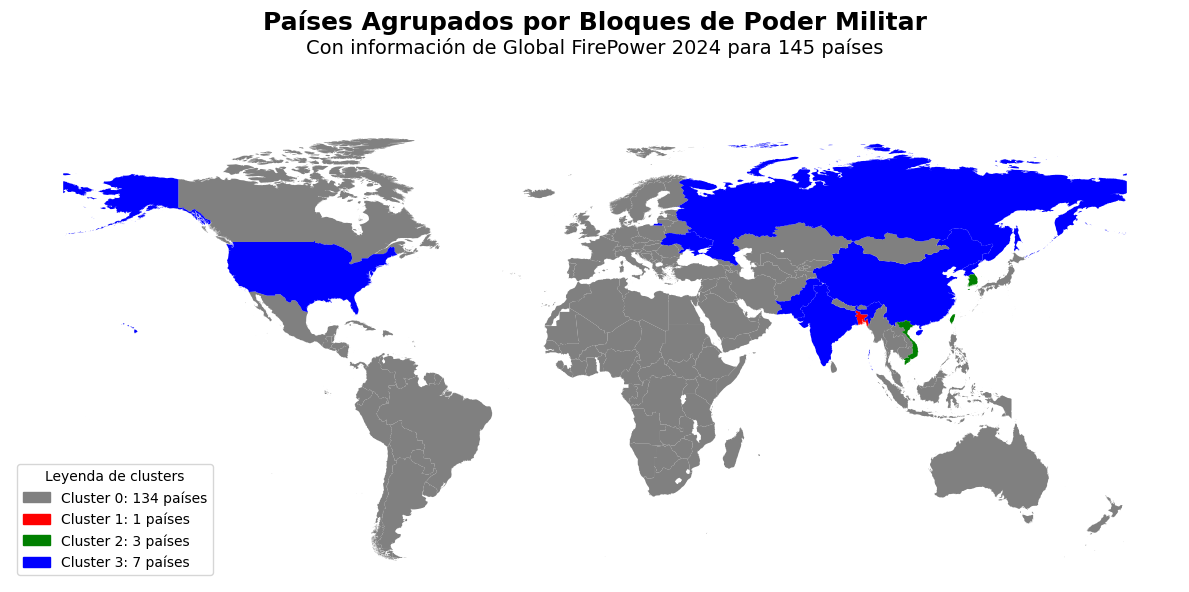

In [20]:
# Genera un canvas para graficar
fig, ax = plt.subplots(figsize=(12, 8))
countries_clusters.plot(color=countries_clusters['color'], ax=ax)

# Add aesthetics
ax.set_xticks([])
ax.set_yticks([])

fig.text(0.5, 0.9, 'Países Agrupados por Bloques de Poder Militar', ha='center', weight='bold', size=18)
fig.text(0.5, 0.87, f'Con información de Global FirePower 2024 para {clusters_summary.paises.sum()} países', ha='center', size=14)

for spine in ['left', 'bottom']:
    ax.spines[spine].set_visible(False)


# Agrega una leyenda personalizada
countries_clusters_summary = (
    countries_clusters
    .groupby(['cluster', 'color'])
    .agg({'country_longName': 'nunique'})
    .reset_index()
)


handles = []
for i, row in countries_clusters_summary.iterrows():
    patch_summary = f"Cluster {row['cluster']}: {row['country_longName']} países"
    patch = mpatches.Patch(color=row['color'], label=patch_summary)
    handles.append(patch)

plt.legend(handles=handles, ncol=1, loc='lower left', title='Leyenda de clusters')

plt.tight_layout()

## Con datos escalados

Cuáles son los países que más se parecen a:
- Japón
- Estados Unidos
- Rusia
- China
- México

In [21]:
# Escala la informacion
scaler = MinMaxScaler()

data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data_scaled.index = data.index
display(data_scaled)

display(data_scaled.describe())

,,Active Service,Active Reserves,Paramilitary,Fighters/Interceptors,Attack/Strike,Helicopter Fleets,Armored Fighting Vehicles,Towed Artillery,Submarines,Frigates,Corvettes
country_longName,country_shortName,,,,,,,,,,,
Afghanistan,AFG,0.000000,0.0000,0.011765,0.000000,0.000000,0.001917,0.017932,0.000000,0.000000,0.000000,0.000000
Albania,ALB,0.003243,0.0004,0.000074,0.000000,0.000000,0.003312,0.002434,0.000000,0.000000,0.000000,0.000000
Algeria,ALG,0.159705,0.0270,0.022059,0.055016,0.046875,0.051944,0.099703,0.057803,0.092308,0.190476,0.192771
Angola,ANG,0.052580,0.0000,0.001471,0.030744,0.029018,0.020220,0.015001,0.066060,0.000000,0.000000,0.000000
Argentina,ARG,0.053071,0.0000,0.002941,0.012945,0.011161,0.015688,0.060072,0.020584,0.030769,0.000000,0.108434
...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,VEN,0.053563,0.0016,0.032353,0.021575,0.000000,0.013073,0.041298,0.012446,0.030769,0.000000,0.000000
Vietnam,VET,0.294840,1.0000,0.036765,0.022114,0.036830,0.017256,0.051332,0.083772,0.092308,0.214286,0.168675
Yemen,YEM,0.032776,0.0000,0.002941,0.028587,0.025670,0.010633,0.013057,0.003112,0.000000,0.000000,0.024096


,Active Service,Active Reserves,Paramilitary,Fighters/Interceptors,Attack/Strike,Helicopter Fleets,Armored Fighting Vehicles,Towed Artillery,Submarines,Frigates,Corvettes
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,0.075619,0.040362,0.017839,0.039735,0.030396,0.025159,0.045666,0.048760,0.050716,0.067159,0.035563
std,0.145872,0.115190,0.089653,0.112805,0.113212,0.088242,0.110594,0.121399,0.154359,0.131123,0.117768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009042,0.000000,0.000294,0.000000,0.000000,0.002266,0.002811,0.000000,0.000000,0.000000,0.000000
50%,0.024570,0.005200,0.001838,0.005933,0.000000,0.006624,0.012284,0.008617,0.000000,0.000000,0.000000
75%,0.079607,0.026000,0.008088,0.028587,0.025670,0.017431,0.037809,0.035902,0.030769,0.095238,0.024096
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
# Agarra una observacion para ver que haga sentido el escalado
class _min_max_scaler():
    def __init__(self, series):
        self.series = series

    def fit(self):
        self.min = self.series.min()
        self.max = self.series.max()

    def predict(self, x):
        return (x - self.min) / (self.max - self.min)

_scaler = _min_max_scaler(data['Active Service'])
_scaler.fit()

# Selecciona observaciones random
np.random.seed(11)
obs_random = np.random.randint(0, 145, 5)


obs_random_df = (pd.DataFrame(data['Active Service']).iloc[obs_random]
                 .merge(data_scaled[['Active Service', 'Paramilitary']], left_index=True, right_index=True,
                        suffixes=['', '_scaled'])
                 .drop('Paramilitary', axis=1)
                )

obs_random_df['Active Service_scaled_v2'] = obs_random_df['Active Service'].apply(lambda x: _scaler.predict(x))
obs_random_df

# Conclusion: Hace sentido

,,Active Service,Active Service_scaled,Active Service_scaled_v2
country_longName,country_shortName,,,
Moldova,MOL,8500,0.004177,0.004177
Niger,NGR,25000,0.012285,0.012285
Mongolia,MGL,35000,0.017199,0.017199
Beliz,BLZ,1650,0.000811,0.000811
Malaysia,MLY,113000,0.055528,0.055528


Text(0.5, 1.05, 'Distribución de las variables')

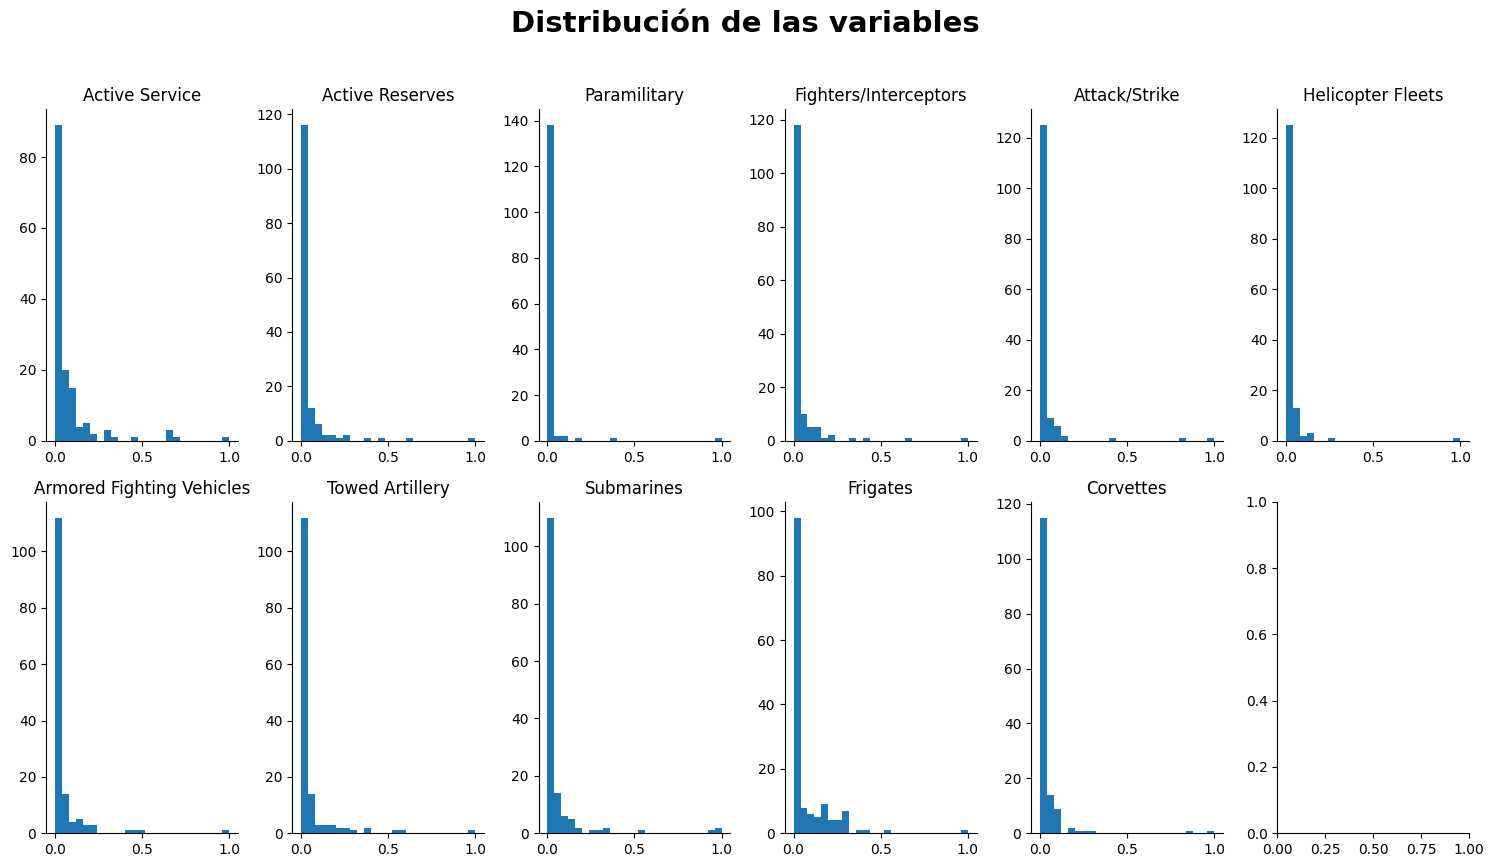

In [23]:
fig, axs = plt.subplots(2, 6, figsize=(15, 8))
axs = axs.flatten()

for i, col in enumerate(data_scaled.columns):
    ax = axs[i]
    ax.hist(data_scaled[col], bins=25)
    ax.set_title(col)

fig.tight_layout()
fig.text(0.5, 1.05, 'Distribución de las variables', weight='bold', ha='center', size=21)

No parece haber mucha diferencia entre escalar y no escalar la información. Mantiene un sesgo a la izquierda.

#### ¿Hay algúna posible correlación?

<Axes: title={'center': 'Correlación líneal de las variables'}>

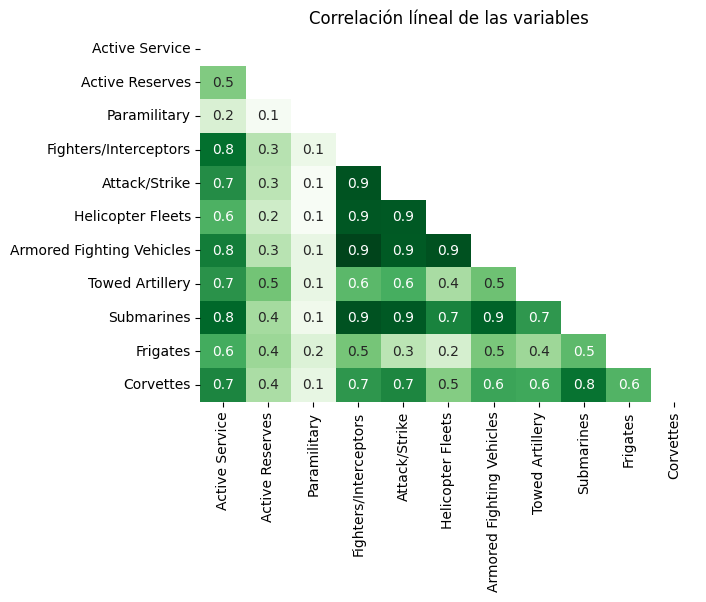

In [24]:
fig, ax = plt.subplots()

ax.set_title('Correlación líneal de las variables')
corr = data_scaled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Genera una mascara para quedarte con el triangulo inferior de la matriz
sns.heatmap(corr, mask=mask, ax=ax, annot=True, fmt='.1f', cmap='Greens', cbar=False)

Lo mismo, parece que el escalado no afecta a la correlación enter las variables. Son muy similares a sin escalar.

#### ¿Es posible reducir la dimensionalidad?

Es posible, pero ¿nos dice algo?

In [25]:
# Intenta con 10 componentes principales y observa que tanta varianza explica
pca = PCA(n_components=10)
pca.fit(data_scaled)

print(round(pca.explained_variance_ratio_[:5].sum(), 2), end='\n\n')
print(round(pca.explained_variance_ratio_[:6].sum(), 2), end='\n\n')

display(list(map(lambda x: round(x, 4), pca.explained_variance_ratio_)))

# Sin escalar
# [0.5025, 0.4181, 0.0786, 0.0008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0.93

0.96



[0.6531,
 0.1079,
 0.0687,
 0.0516,
 0.0476,
 0.0287,
 0.0229,
 0.0105,
 0.0041,
 0.0034]

Interesante que si se escalan los datos, el mismo primer componente explica más que sin escalar (0.65 vs. 0.5025). De igual forma el segundo component principal al escalar parece que ya no captura tanta varianza como antes (0.1079 vs. 0.0687).

Para capturar la misma varianza de ~0.93 que un `PCA` con datos no escalados con 2 componentes, con información escalada se necesitan 5 componentes.

Para poder acumular el ~95% de la varianza es necesario 6 componentes. Es una buena opción para reducir la dimensionalidad.

Transforma la información inicial con el `PCA` entrenado

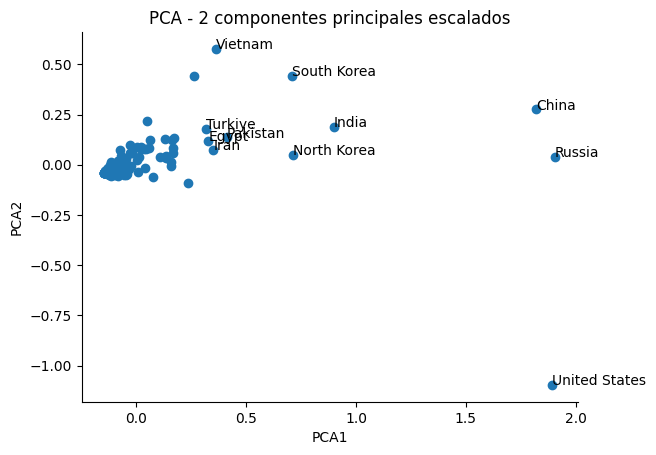

In [26]:
# Genera un dataframe y dale el formato necesario (nombre de columnas/indice)
data_pca_scaled = pd.DataFrame(pca.transform(data_scaled))
data_pca_scaled.columns = [f'PCA{i+1}' for i in data_pca_scaled.columns]
data_pca_scaled.index = data.index
data_pca_scaled = data_pca_scaled[['PCA1', 'PCA2']]

###############
# Grafica
###############
fig, ax = plt.subplots()
ax.scatter(data_pca_scaled['PCA1'], data_pca_scaled['PCA2'])

# Para aquellos paises que no estan concentrados, entonces graficalos
for index, row in data_pca_scaled.sort_values('PCA1', ascending=False).iloc[:11].iterrows():
    ax.text(row['PCA1'], row['PCA2'], index[0])

# Agrega aes
ax.set_title('PCA - 2 componentes principales escalados')
ax.set_xlabel('PCA1')

_ = ax.set_ylabel('PCA2')

- Interesante ver como con datos escalados cambia la visualización. Es de esperar por el posible cambio en la varianza capturada por los dos primeros componentes principales.
- Ahora **China**, **Rusia** y **Estados Unidos** estan en la periferia y ya no estan concentrados junto con los otros países
- Llama la atención como países que son cercanos geográficamente como **Turquía**, **Iran**, **Egypto** y **Pakistan** esten tan juntos

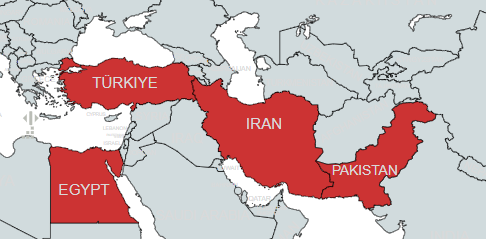

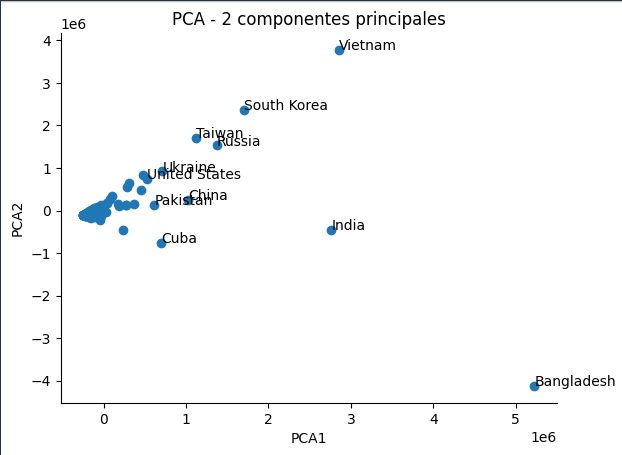

#### Calcula el `k` clusters óptimo

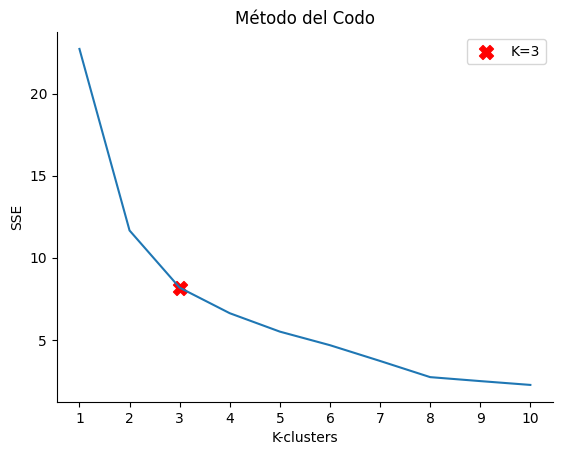

In [27]:
# Obten el WCSS de cada uno de los k clusters
WCSS = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=10000, random_state=11)
    kmeans.fit(data_scaled)
    WCSS.append(kmeans.inertia_)


# Grafica el codo
fig, ax = plt.subplots()
_ = np.arange(1, len(WCSS)+1)
ax.plot(_, WCSS)
ax.scatter(3, WCSS[2], color='red', marker='X', s=100, label='K=3')
plt.legend()

ax.set_xticks(_)
ax.set_xlabel('K-clusters')
ax.set_ylabel('SSE')
_ = ax.set_title('Método del Codo')

Llama la atención como en esta ocasión se ve más claro que el codo esta en 3 números de clusters.

In [32]:
# Entrena el algoritmo y predice
kmeans_scaled = KMeans(n_clusters=3, random_state=11)
kmeans_scaled.fit(data_scaled)

data_cluster_scaled = data_scaled.copy()
data_cluster_scaled['cluster'] = kmeans_scaled.predict(data_cluster_scaled)
data_cluster_scaled = data_cluster_scaled.reset_index()

# Cual es el numero de paises que se agruparon?
data_cluster_scaled.groupby('cluster')['country_shortName'].nunique()

cluster
0    132
1      3
2     10
Name: country_shortName, dtype: int64

In [33]:
for cluster, cluster_df in data_cluster_scaled.groupby('cluster'):
    print(f'> cluster={cluster}')
    display(cluster_df[['country_longName', 'country_shortName']].head(10))
    print()

> cluster=0


,country_longName,country_shortName
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,ALG
3,Angola,ANG
4,Argentina,ARG
5,Armenia,ARM
6,Australia,AUS
7,Austria,AST
8,Azerbaijan,AZR
9,Bahrain,BAH



> cluster=1


,country_longName,country_shortName
28,China,CHN
107,Russia,RUS
137,United States,USA



> cluster=2


,country_longName,country_shortName
37,Egypt,EGY
53,India,IND
55,Iran,IRN
93,North Korea,NKO
97,Pakistan,PAK
117,South Korea,SKO
126,Taiwan,TWN
131,Turkiye,TKY
134,Ukraine,UKR
141,Vietnam,VET


Algo similar con data escalada, gran parte de los países están dentro de un mismo cluster. Y sólo 13 estan repartidos en los 2 clusters restantes.

Lo que de igual forma llama la atención es que se genera un cluster en el que están las principales potencias reconocidas por su poder militar **Estados Unidos**, **Rusia** y **China**.

In [35]:
kmeans_centroids_scaled = pd.DataFrame(kmeans_scaled.cluster_centers_, columns=data_scaled.columns)

display(
    kmeans_centroids_scaled
    .style
    .background_gradient(cmap='Greens', subset=['Active Service'])
    .background_gradient(cmap='Greens', subset=['Active Reserves'])
    .background_gradient(cmap='Greens', subset=['Paramilitary'])
    .background_gradient(cmap='Greens', subset=['Fighters/Interceptors'])
    .background_gradient(cmap='Greens', subset=['Attack/Strike'])
    .background_gradient(cmap='Greens', subset=['Helicopter Fleets'])
    .background_gradient(cmap='Greens', subset=['Armored Fighting Vehicles'])
    .background_gradient(cmap='Greens', subset=['Towed Artillery'])
    .background_gradient(cmap='Greens', subset=['Submarines'])
    .background_gradient(cmap='Greens', subset=['Frigates'])
    .background_gradient(cmap='Greens', subset=['Corvettes'])
    .format('{:,.3f}')
)


,Active Service,Active Reserves,Paramilitary,Fighters/Interceptors,Attack/Strike,Helicopter Fleets,Armored Fighting Vehicles,Towed Artillery,Submarines,Frigates,Corvettes
0,0.039,0.016,0.014,0.016,0.011,0.012,0.024,0.022,0.018,0.045,0.017
1,0.767,0.221,0.043,0.696,0.743,0.476,0.644,0.441,0.974,0.429,0.715
2,0.351,0.302,0.064,0.152,0.070,0.063,0.153,0.288,0.203,0.252,0.083


In [36]:
# Define una tabla con el resumen de los clusters, paises, que color, descripcion
clusters_summary_scaled = (pd.DataFrame(data_cluster_scaled.groupby('cluster')['country_shortName'].count())
                            .reset_index()
                            .rename(columns={'country_shortName': 'paises'})
                           )

clusters_summary_scaled['color'] = ['gray', 'red', 'green']
clusters_summary_scaled['desc'] = [
    'Poder militar bajo',
    'Poder militar alto',
    'Poder militar regular'
]
clusters_summary_scaled

,cluster,paises,color,desc
0,0,132,gray,Poder militar bajo
1,1,3,red,Poder militar alto
2,2,10,green,Poder militar regular


In [37]:
# Une la informacion geografica con la del cluster para poder visualizar los clusters
countries_clusters_scaled = (pd.merge(data_cluster_scaled[['country_longName', 'country_shortName', 'cluster']],
                              countries,
                              left_on='country_longName', right_on='ADMIN',
                              how='left')
                              .merge(clusters_summary,
                                    on='cluster',
                                    how='left'
                                   )
                              .set_geometry('geometry')
                             )

# Obten el centroide del pais
countries_clusters_scaled['centroid'] = countries_clusters_scaled['geometry'].centroid

countries_clusters_scaled.info()
countries_clusters_scaled.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country_longName   145 non-null    object  
 1   country_shortName  145 non-null    object  
 2   cluster            145 non-null    int32   
 3   ADMIN              145 non-null    object  
 4   ISO_A3             145 non-null    object  
 5   ISO_A2             145 non-null    object  
 6   geometry           145 non-null    geometry
 7   paises             145 non-null    int64   
 8   color              145 non-null    object  
 9   desc               145 non-null    object  
 10  centroid           145 non-null    geometry
dtypes: geometry(2), int32(1), int64(1), object(7)
memory usage: 12.0+ KB


,country_longName,country_shortName,cluster,ADMIN,ISO_A3,ISO_A2,geometry,paises,color,desc,centroid
0,Afghanistan,AFG,0,Afghanistan,AFG,AF,"MULTIPOLYGON (((71.0498 38.40866, 71.05714 38....",134,gray,Poder militar regular,POINT (66.00845 33.83627)
1,Albania,ALB,0,Albania,ALB,AL,"MULTIPOLYGON (((19.74777 42.5789, 19.74601 42....",134,gray,Poder militar regular,POINT (20.05382 41.14248)
2,Algeria,ALG,0,Algeria,DZA,DZ,"MULTIPOLYGON (((8.60251 36.93951, 8.60566 36.9...",134,gray,Poder militar regular,POINT (2.65309 28.14889)
3,Angola,ANG,0,Angola,AGO,AO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",134,gray,Poder militar regular,POINT (17.53698 -12.29232)
4,Argentina,ARG,0,Argentina,ARG,AR,"MULTIPOLYGON (((-68.65412 -54.88624, -68.65414...",134,gray,Poder militar regular,POINT (-65.17819 -35.38755)


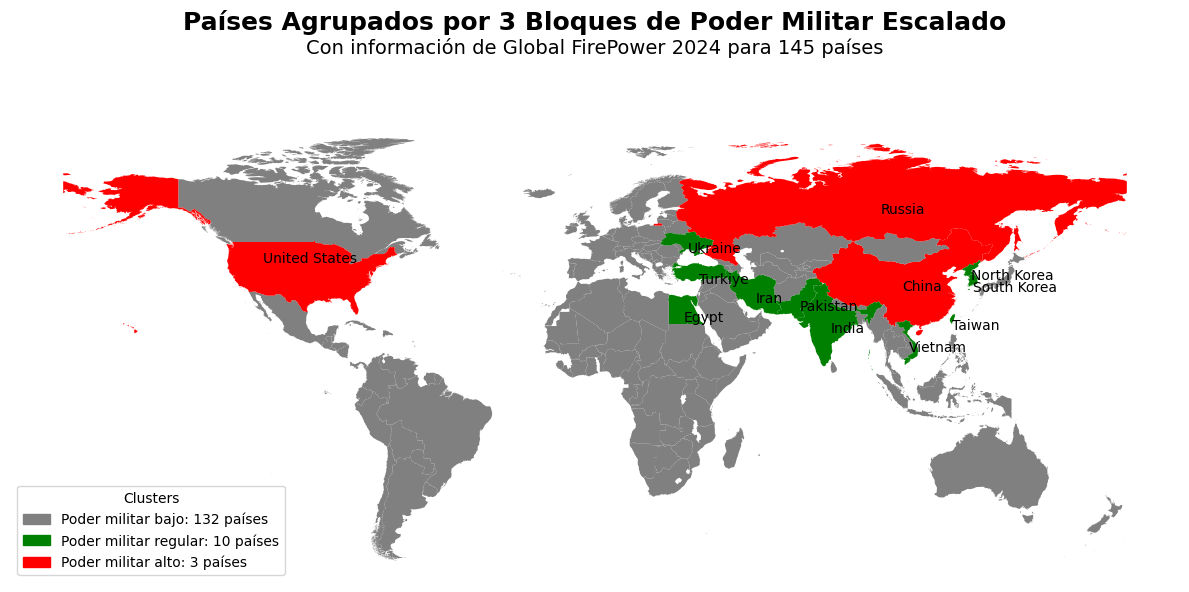

In [44]:
# Genera un canvas para graficar
fig, ax = plt.subplots(figsize=(12, 8))
countries_clusters_scaled.plot(color=countries_clusters_scaled['color'], ax=ax)

# Add aesthetics
ax.set_xticks([])
ax.set_yticks([])

fig.text(0.5, 0.9, f'Países Agrupados por {countries_clusters_scaled["cluster"].nunique()} Bloques de Poder Militar Escalado', ha='center', weight='bold', size=18)
fig.text(0.5, 0.87, f'Con información de Global FirePower 2024 para {clusters_summary_scaled.paises.sum()} países', ha='center', size=14)

for spine in ['left', 'bottom']:
    ax.spines[spine].set_visible(False)


# Agrega una leyenda personalizada
handles = []
for i, row in clusters_summary_scaled.sort_values('paises', ascending=False).iterrows():
    patch_summary = f"{row['desc']}: {row['paises']} países"
    patch = mpatches.Patch(color=row['color'], label=patch_summary)
    handles.append(patch)

for i, row in countries_clusters_scaled.iterrows():
    if row['cluster'] in [1, 2]:
        ax.text(row['centroid'].x, row['centroid'].y, row['country_longName'], va='top')

plt.legend(handles=handles, ncol=1, loc='lower left', title='Clusters')

plt.tight_layout()

## Referencias

- Gilabert, O. (2024). Entendiendo el Within Cluster Sum of Squares (WCSS). Medium. Recuperado de: https://medium.com/@oriolgilabertlopez/entendiendo-el-within-cluster-sum-of-squares-wcss-14935cb64672
- Mapchart.net. (2024). World Map: Simple. https://www.mapchart.net/world.html